# 技术分析交易策略

In [71]:
# | code-fold: true
# 以下都是例行公事，直接拷贝即可

import pandas as pd
import numpy as np 

# 导入matplotlib.pyplot绘图库，其中plt.plot()是最常用的绘图函数之一
import matplotlib.pyplot as plt 

import seaborn as sns

sns.set_theme() # 默认用seaborn的绘图样式

plt.rcParams["font.sans-serif"]=["Microsoft YaHei"] #设置字体。如果不设置，中文会乱码。这里采用微软雅黑'Microsoft YaHei'，如果显示不正常，也可以使用黑体'SimHei'或者宋体'SimSun'等
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 绘图使用'svg'后端：svg是矢量格式，可以任意缩放均保持清晰，各种屏幕的显示良好。
%config InlineBackend.figure_formats = ['svg']

传统的技术分析技术怎么在Python中应用，包括绘制指标，以及交易的回测。

主要包括：

1. 趋势交易：双均线系统为例
2. 波动交易：RSI系统为例
3. 指标综合：结合前两者

注意：以下策略均未考虑交易成本。如果要考虑，只要在交易日乘以一个系数(1-交易成本)即可。

## 简单移动平均策略

从最简单的双均线交易系统开始：设置2条均线，当快速均线位于慢速均线上方，则持有；反之则空仓。

1. 绘制均线
2. 计算交易信号
3. 计算交易的收益率
4. 绘制交易结果

### 读取数据

这里简单演示一下如何用akshare包来读取数据。akshare官方主页见https://www.akshare.xyz/。

如果要在你的电脑上安装akshare包（这里采用清华大学的镜像），有几种方法：

1. 在jupyter notebook中，找一个python单元格，然后粘贴如下代码，并执行:

```
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple akshare
```

2. 启动Anaconda Prompt（开始菜单中有），或者Mac系统的终端(Terminal)，执行如下命令，则会从清华大学的镜像安装akshare到你的电脑上。

```
pip install -i https://pypi.tuna.tsinghua.edu.cn/simple akshare
```

上述方法2选1，并且都只需要执行一次，以后都可以使用。

In [72]:
import akshare as ak

这里以锂电池龙头宁德时代为例。

In [73]:
# 读取宁德时代
# 见：https://akshare.xyz/data/stock/stock.html#id20

df = ak.stock_zh_a_hist(symbol="300750",start_date='20180101',end_date='20241231', adjust='qfq')

df

,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2018-06-11,300750,9.64,12.99,12.99,9.64,788,2.845471e+06,48.98,89.91,6.15,0.04
1,2018-06-12,300750,15.00,15.00,15.00,15.00,266,1.058375e+06,0.00,15.47,2.01,0.01
2,2018-06-13,300750,17.21,17.21,17.21,17.21,450,1.972314e+06,0.00,14.73,2.21,0.02
3,2018-06-14,300750,19.64,19.64,19.64,19.64,743,3.578184e+06,0.00,14.12,2.43,0.03
4,2018-06-15,300750,22.32,22.32,22.32,22.32,2565,1.359503e+07,0.00,13.65,2.68,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...
1572,2024-12-02,300750,258.64,262.19,263.55,257.21,206475,5.387883e+09,2.43,0.36,0.95,0.53
1573,2024-12-03,300750,261.00,261.84,262.99,259.00,173108,4.514868e+09,1.52,-0.13,-0.35,0.44
1574,2024-12-04,300750,260.00,258.97,262.00,257.50,161814,4.186965e+09,1.72,-1.10,-2.87,0.41
1575,2024-12-05,300750,257.99,256.00,258.95,255.01,160216,4.109014e+09,1.52,-1.15,-2.97,0.41


### 评价策略的标准

评价策略的方法有很多，这里以夏普比率为例。夏普比率要回答的问题是：1单位风险，可以获得多少单位的超额收益？

需要前置知识：对数收益率和夏普比率的计算，见投资组合理论的章节。

和前面的章节一样，我们全部的计算采用收益率来进行，而不是具体的收盘价。首先获得收益率的时间序列：

In [74]:
df['日期'] = pd.to_datetime(df['日期'])
df.set_index('日期',inplace = True)

In [75]:
df = df[['涨跌幅']]/100
df.fillna(0,inplace=True)
df.tail()

,涨跌幅
日期,
2024-12-02,0.0036
2024-12-03,-0.0013
2024-12-04,-0.0110
2024-12-05,-0.0115
2024-12-06,0.0412


从上市之日，投资1元到今天的结果。

In [76]:
df['price'] = (df['涨跌幅'] + 1).cumprod() # 用涨跌幅反算出复权价，上市日前一天为1。
df

,涨跌幅,price
日期,,
2018-06-11,0.8991,1.899100
2018-06-12,0.1547,2.192891
2018-06-13,0.1473,2.515904
2018-06-14,0.1412,2.871149
2018-06-15,0.1365,3.263061
...,...,...
2024-12-02,0.0036,38.353492
2024-12-03,-0.0013,38.303632
2024-12-04,-0.0110,37.882292


<Axes: xlabel='日期'>

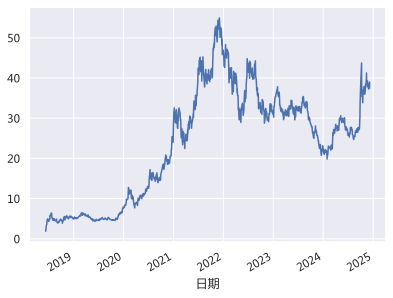

In [77]:
df.price.plot()

计算对数收益率、标准差，以及夏普比率：

In [78]:
# 计算对数收益率
df['lrets'] = np.log(df['涨跌幅'] + 1)
df.tail()

,涨跌幅,price,lrets
日期,,,
2024-12-02,0.0036,38.353492,0.003594
2024-12-03,-0.0013,38.303632,-0.001301
2024-12-04,-0.0110,37.882292,-0.011061
2024-12-05,-0.0115,37.446646,-0.011567
2024-12-06,0.0412,38.989447,0.040374


In [79]:
# 计算年化对数收益率

np.mean(df.lrets) * 250

0.5807373228441678

In [80]:
# 年化对数SD
np.std(df.lrets) * np.sqrt(250)

0.5799130168762349

In [81]:
# 简单算一下夏普比率: 每单位风险，能够获得多少超额收益。
rf = 0.03

(np.mean(df.lrets) * 250 - rf) / (np.std(df.lrets) * np.sqrt(250))

0.9496895341490605

把上述过程写成一个函数：参数是对数收益率序列，返回值是这个序列的夏普比率：

In [82]:
# 写成函数
def sharpe_ratio(lrets, rf = 0.03):
    return (np.mean(lrets) * 250 - rf) / (np.std(lrets) * np.sqrt(250))


# 简单测试一下范例股票的夏普比率
sharpe_ratio(df.lrets)

0.9496895341490605

显然，一只股票（或者任何证券合约）本身的夏普比率，可以理解为对这只股票实行“买入并持有+分红再投资”的策略的夏普比率。

### 均线计算

第一个策略是经典的“双均线”策略：快均线高于慢均线，则持有；反正则空仓（或者做空，后面有范例）

首先均线计算均线并绘制，先随选2个周期：

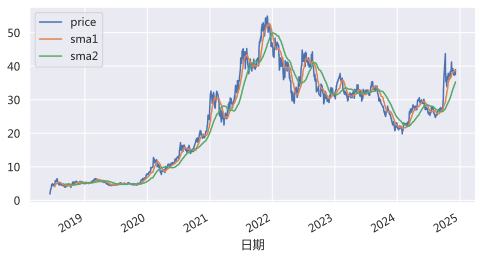

In [83]:
# 2个均线周期
sma1 = 20
sma2 = 60

def sma(x,period):
    return x.rolling(period).mean()

def ema(x,period):
    return x.ewm(span=period,min_periods=0,adjust=False,ignore_na=False).mean()

df.loc[:,'sma1'] = sma(df.price,sma1)
df.loc[:,'sma2'] = sma(df.price,sma2)

df[['price','sma1','sma2']].plot(figsize=(8,4));

### 交易策略(只做多)

首先假定我们只能做多。

如果快均线高于慢均线：买入持有；反之空仓。


In [84]:
df['pos'] = np.where(df['sma1'] > df['sma2'],1,0) # np.where()生成一个序列，条件成立则1，反之则0
df.tail()

,涨跌幅,price,lrets,sma1,sma2,pos
日期,,,,,,
2024-12-02,0.0036,38.353492,0.003594,38.662541,34.548544,1
2024-12-03,-0.0013,38.303632,-0.001301,38.666255,34.737555,1
2024-12-04,-0.0110,37.882292,-0.011061,38.684647,34.927227,1
2024-12-05,-0.0115,37.446646,-0.011567,38.635114,35.098774,1
2024-12-06,0.0412,38.989447,0.040374,38.701542,35.292367,1


把指标和持仓情况并列绘制

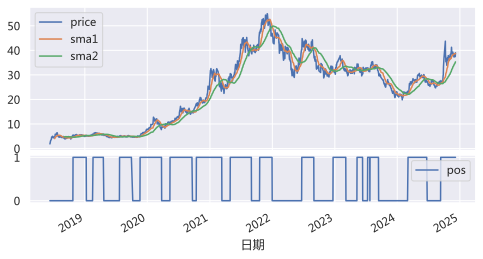

In [85]:
# 绘制子图，见前面的章节。height_ratios是子图的高度比例
fig, axes = plt.subplots(2,1,figsize=(8,4), gridspec_kw={'height_ratios': [3, 1]},sharex = True)

df[['price','sma1','sma2']].plot(ax = axes[0])
df[['pos']].plot(ax = axes[1])

plt.subplots_adjust(wspace=0.05,hspace=0.05)

注意，仓位`pos=1`的时候，表示持有：反正则表示空仓，因此上图可以看出持仓的状态。

### 从持仓计算收益率的序列

从持仓出发，计算策略的收益率，原理很简单：只要 `持仓pos * 收益率序列lret` 即可：持仓为1，则存在收益率；持仓为0，则收益率为0；

1. `df['pos']`中，1表示持仓，0表示空仓
2. `df['lrets']`表示每天的对数收益率。
3. `df['lrets'] * df.lrets`，两个序列相乘，就可以得到执行策略的收益率序列：空仓日收益率为0，持仓日收益率为lret。
4. 今天出信号，收盘进行操作，实际收益在明天才能兑现。因此pos要滞后1天（**重要**：避免自我欺骗）


In [86]:
# 交易策略的收益率
df['strategy'] = df['pos'].shift(1) * df.lrets

df.dropna(inplace=True)

df.round(4).head()

,涨跌幅,price,lrets,sma1,sma2,pos,strategy
日期,,,,,,,
2018-09-03,-0.0424,4.0969,-0.0433,4.6636,4.7089,0,-0.0
2018-09-04,0.0118,4.1452,0.0117,4.6233,4.7463,0,0.0
2018-09-05,-0.0483,3.9450,-0.0495,4.5821,4.7755,0,-0.0
2018-09-06,0.0093,3.9817,0.0093,4.5325,4.7999,0,0.0
2018-09-07,0.0301,4.1016,0.0297,4.4874,4.8204,0,0.0


比较一下股票本身（买入并持有）和 双均线系统 两者:

（注意我们的均线是随意选择的）

In [87]:
# 年化对数收益率
df[['lrets','strategy']].agg("mean")*250

lrets       0.363922
strategy    0.270519
dtype: float64

In [88]:
# 夏普比率
df[['lrets','strategy']].agg(sharpe_ratio)

lrets       0.678974
strategy    0.619864
dtype: float64

观察年化收益率和夏普比率。

绘制两者的对比曲线：正如均线系统的特征，能够过滤掉大幅度的下跌，对顶部和底部的判断有明显的滞后。

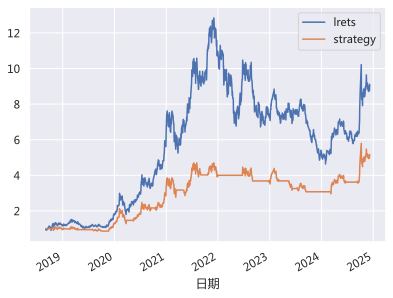

In [89]:
df[['lrets','strategy']].cumsum().apply(np.exp).plot();

### 使用暴力优化

参数优化：寻找最佳参数

暴力参数优化：使用穷举法，寻找最佳参数。

1. 罗列一系列双均线的周期组合
2. 对每个都计算收益率和夏普比率
3. 按某个标准(这里采用夏普比率)，选出历史最佳
4. 扩展：历史最佳不代表未来最佳，进一步内容见滚动窗口测试


先把要用到的数据放在一个df中：从收益率反算的价格，收益率，均线1，均线2，持仓状态，策略收益率

In [90]:
%%capture --no-display 
# 这一行用于忽略本cell的warning

sma1 = 10
sma2 = 60
data = df[['price','lrets']]

# def test(sma1, sma2, data):
data['sma1'] = sma(data.price, sma1)
data['sma2'] = sma(data.price, sma2)

data['pos'] = np.where(data['sma1'] > data['sma2'], 1, 0)

data['strategy'] = data['pos'].shift(1) * data.lrets

data.dropna(inplace = True)

data.head()

,price,lrets,sma1,sma2,pos,strategy
日期,,,,,,
2018-12-03,5.524623,0.012027,5.261774,4.840392,1,0.000000
2018-12-04,5.642850,0.021174,5.298584,4.866158,1,0.021174
2018-12-05,5.566671,-0.013592,5.320604,4.889848,1,-0.013592
2018-12-06,5.375178,-0.035006,5.329461,4.913684,1,-0.035006
2018-12-07,5.430542,0.010247,5.375893,4.937831,1,0.010247


为例比较不同均线的策略效果，要从数据中获得获得这几样：

1. 股票原来的年化收益率和年化夏普比率
2. 含有交易策略的年化收益率和年化夏普比率

In [91]:
asset_rets = np.mean(data.lrets) * 250
asset_sr = sharpe_ratio(data.lrets)

strat_rets = np.mean(data.strategy) * 250
start_sr = sharpe_ratio(data.strategy)

result = pd.DataFrame(dict(asset_rets=asset_rets, # 资产收益率
                           asset_sr=asset_sr, # 资产夏普比率
                           strat_rets=strat_rets, # 策略收益率
                           start_sr=start_sr, # 策略夏普比率
                           diff_rets = strat_rets - asset_rets, # 收益差
                           diff_sr= start_sr - asset_sr # 夏普比率的差
                           ), index=[0])

result


,asset_rets,asset_sr,strat_rets,start_sr,diff_rets,diff_sr
0,0.336892,0.638996,0.283209,0.663585,-0.053684,0.024589


我们的目标是：给定数据，指定2个均线周期，就可以计算出这个双均线策略在某个股票上的策略收益率和一系列指标：

把上述代码写成一个函数：

In [92]:
%%capture --no-display 
# 这一行用于忽略本cell的warning


def test(sma1, sma2, data):
    data['sma1'] = sma(data.price, sma1)
    data['sma2'] = sma(data.price, sma2)

    data['pos'] = np.where(data['sma1'] > data['sma2'], 1, 0)

    data['strategy'] = data['pos'].shift(1) * data.lrets

    data.dropna(inplace = True)

    asset_rets = np.mean(data.lrets) * 250
    asset_sr = sharpe_ratio(data.lrets)

    strat_rets = np.mean(data.strategy) * 250
    start_sr = sharpe_ratio(data.strategy)

    result = pd.DataFrame(dict(sma1 = sma1 ,sma2=sma2, 股票收益率=asset_rets,
                            股票sr=asset_sr,
                            策略收益率=strat_rets,
                            策略sr=start_sr,
                            收益率差异 = strat_rets - asset_rets,
                            sr差异= start_sr - asset_sr
                            ), index=[0])

    return result

循环并罗列所有结果

In [93]:
%%capture --no-display 
# 这一行用于忽略本cell的warning

from itertools import product

# 设定一系列快和慢均线
sma1 = range(10,56,5) 
sma2 = range(60,251,10)

result = []
# 对这些均线的两两组合进行测试
for SMA1, SMA2 in product(sma1,sma2):
    #print(f"{SMA1=},{SMA2=}")
    result.append(test(SMA1, SMA2, df[['price','lrets']]))

# 按夏普比率排序
result = pd.concat(result).sort_values('策略sr',ascending=False).head(5)
result


,sma1,sma2,股票收益率,股票sr,策略收益率,策略sr,收益率差异,sr差异
0,25,190,0.396889,0.754884,0.412775,0.959406,0.015885,0.204522
0,25,200,0.399962,0.759029,0.394335,0.906847,-0.005626,0.147818
0,30,200,0.399962,0.759029,0.391032,0.897126,-0.008929,0.138098
0,30,220,0.384623,0.724243,0.391495,0.892670,0.006871,0.168427
0,20,210,0.397232,0.751872,0.388946,0.887372,-0.008286,0.135500


注意看，最优策略的夏普比率比买入并持有高一些。

利用暴力求解（穷举法），可以得到任何2组均线的策略收益率和策略夏普比率。可以带入前面的代码查看效果。

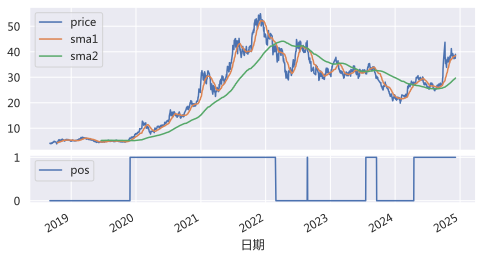

In [94]:
sma1 = int(result.iloc[0]['sma1'])
sma2 = int(result.iloc[0]['sma2'])

df.loc[:,'sma1'] = sma(df.price,sma1)
df.loc[:,'sma2'] = sma(df.price,sma2)

df['pos'] = np.where(df['sma1'] > df['sma2'],1,0)

fig, axes = plt.subplots(2,1,figsize=(8,4), gridspec_kw={'height_ratios': [3, 1]},sharex = True)
df[['price','sma1','sma2']].plot(ax = axes[0])
df[['pos']].plot(ax = axes[1])

plt.subplots_adjust(wspace=0.05,hspace=0.05)

把新获得的策略收益曲线并入原来的数据中，对比三者：

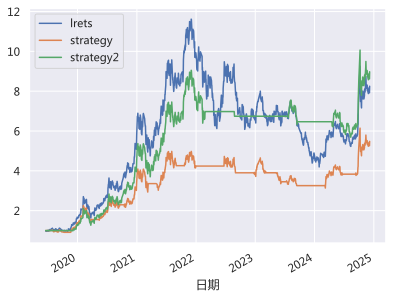

In [95]:
df.loc[:,'strategy2'] = df['pos'].shift(1) * df.lrets

df.dropna(inplace=True)

df.round(4).head()

df[['lrets','strategy','strategy2''']].cumsum().apply(np.exp).plot();

### 交易策略（多空）

如果允许做空， 则把空仓信号从`0` 改为做空信号 `-1`。

In [96]:
df['pos'] = np.where(df['sma1'] > df['sma2'],1,-1) # np.where()生成一个序列，条件成立则1，反之则-1
df.tail()

,涨跌幅,price,lrets,sma1,sma2,pos,strategy,strategy2
日期,,,,,,,,
2024-12-02,0.0036,38.353492,0.003594,38.202791,29.346846,1,0.003594,0.003594
2024-12-03,-0.0013,38.303632,-0.001301,38.261966,29.428912,1,-0.001301,-0.001301
2024-12-04,-0.0110,37.882292,-0.011061,38.326235,29.508642,1,-0.011061,-0.011061
2024-12-05,-0.0115,37.446646,-0.011567,38.385122,29.589537,1,-0.011567,-0.011567
2024-12-06,0.0412,38.989447,0.040374,38.504426,29.677146,1,0.040374,0.040374


制作一个做空版本的测试函数

In [97]:
def test2(sma1, sma2, data):
    data['sma1'] = sma(data.price, sma1)
    data['sma2'] = sma(data.price, sma2)

    data['pos'] = np.where(data['sma1'] > data['sma2'], 1, -1) # 这里改了一下

    data['strategy'] = data['pos'].shift(1) * data.lrets

    data.dropna(inplace = True)

    asset_rets = np.mean(data.lrets) * 250
    asset_sr = sharpe_ratio(data.lrets)

    strat_rets = np.mean(data.strategy) * 250
    start_sr = sharpe_ratio(data.strategy)

    result = pd.DataFrame(dict(sma1 = sma1 ,sma2=sma2, 股票收益率=asset_rets,
                            股票sr=asset_sr,
                            策略收益率=strat_rets,
                            策略sr=start_sr,
                            收益率差异 = strat_rets - asset_rets,
                            sr差异= start_sr - asset_sr
                            ), index=[0])

    return result

In [98]:
%%capture --no-display 
# 这一行用于忽略本cell的warning

from itertools import product

sma1 = range(10,56,5) 
sma2 = range(60,251,10)

result = []
for SMA1, SMA2 in product(sma1,sma2):
    #print(f"{SMA1=},{SMA2=}")
    result.append(test2(SMA1, SMA2, df[['price','lrets']]))

result2 = pd.concat(result).sort_values('策略sr',ascending=False).head(5)
result2 

,sma1,sma2,股票收益率,股票sr,策略收益率,策略sr,收益率差异,sr差异
0,25,190,0.329172,0.624856,0.479609,0.940059,0.150437,0.315203
0,25,200,0.334532,0.634458,0.446347,0.868069,0.111815,0.233611
0,30,200,0.334532,0.634458,0.434458,0.843203,0.099925,0.208745
0,20,200,0.334532,0.634458,0.413797,0.800009,0.079265,0.165551
0,15,200,0.334532,0.634458,0.400801,0.772847,0.066268,0.138390


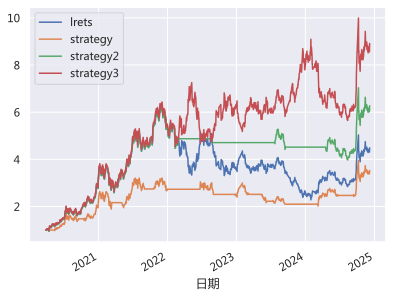

In [99]:
sma1 = int(result2.iloc[0]['sma1'])
sma2 = int(result2.iloc[0]['sma2'])

df.loc[:,'sma1'] = sma(df.price,sma1)
df.loc[:,'sma2'] = sma(df.price,sma2)

df['pos'] = np.where(df['sma1'] > df['sma2'],1,-1)

df['strategy3'] = df['pos'].shift(1) * df.lrets

df.dropna(inplace=True)

df.round(4).head()

df[['lrets','strategy','strategy2','strategy3']].cumsum().apply(np.exp).plot();

### 注意事项

1. 过去不代表未来，过去几年的最优策略，未来不一定成功（其实是基本不会成功）。
2. 可以考虑采用滚动的窗口测试（略）

## 摆动指标

这里以RSI指标为例。

In [100]:
def rsi(close, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [101]:
# 先把数据还原一下
df = df[['lrets','price']]
df

,lrets,price
日期,,
2020-03-27,-0.008637,8.616057
2020-03-30,0.005783,8.666030
2020-03-31,0.010049,8.753557
2020-04-01,0.000000,8.753557
2020-04-02,0.029267,9.013537
...,...,...
2024-12-02,0.003594,38.353492
2024-12-03,-0.001301,38.303632
2024-12-04,-0.011061,37.882292


RSI指标的周期，我们暂定为14天。（显然这个值也是可以被优化的）

In [102]:
rsi_14 = rsi(df.price)
rsi_14[-5:]

日期
2024-12-02    53.240396
2024-12-03    52.992251
2024-12-04    50.835975
2024-12-05    48.632516
2024-12-06    55.919401
Name: price, dtype: float64

绘图：

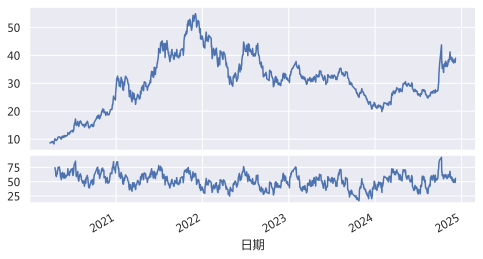

In [103]:
fig, axes = plt.subplots(2,1,figsize=(8,4), gridspec_kw={'height_ratios': [3, 1]},sharex = True)

df.price.plot(ax = axes[0])
rsi_14.plot(ax = axes[1])

plt.subplots_adjust(wspace=0.05,hspace=0.05)

简单的RSI指标策略：

1. RSI小于某个值：买入，并持有到卖出。
2. RSI大于某个值：卖出，并等待到买入。

这里随便选择2个阈值：（连同rsi的周期，现在有3个可优化的值）


对于这种“买入卖出信号”的类型，如何计算持仓状态？

1. 从第一天开始，遍历每一天。
2. 检查买入信号是否为1，是，则position[i] = 1；
3. 检查卖出信号是否为1，是，则position[i] = 0；
4. 2个信号都不存在，则保持前值。

注意：

1. 这里的参数是随便选的，这里只是做演示。
2. 任何其他摆动指标，比如kdj，做法类似

In [104]:
# 构造买卖信号
long_signal = (rsi_14 < 35)
short_signal = (rsi_14 > 70)

In [105]:
position = np.zeros_like(rsi_14)  # 创建一个rsi_14同等长度的序列，其中填满0，即默认空仓


# 遍历rsi_14，这里其实只是要个序号i = [0,1,2,3, .... ]
for i in range(len(rsi_14)):
    if np.isnan(long_signal.iloc[i]) or np.isnan(short_signal.iloc[i]):  # 2个信号有1个是na，就保持0
        position[i] = 0
    else:
        if long_signal.iloc[i]:  # 如果i这天有买入信号
            position[i] = 1  # i这天的持仓为1
        elif short_signal.iloc[i]:  # 如果i这个天有卖出信号
            position[i] = 0  # i这天的持仓为0
        else:
            position[i] = position[i-1] # 没信号，则持仓状态不变


df.loc[:,'pos'] = pd.Series(position,name = 'pos', index = rsi_14.index) # 构造一个Series
df

/tmp/ipykernel_201758/3803281943.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'pos'] = pd.Series(position,name = 'pos', index = rsi_14.index) # 构造一个Series


,lrets,price,pos
日期,,,
2020-03-27,-0.008637,8.616057,0.0
2020-03-30,0.005783,8.666030,0.0
2020-03-31,0.010049,8.753557,0.0
2020-04-01,0.000000,8.753557,0.0
2020-04-02,0.029267,9.013537,0.0
...,...,...,...
2024-12-02,0.003594,38.353492,0.0
2024-12-03,-0.001301,38.303632,0.0
2024-12-04,-0.011061,37.882292,0.0


绘图：

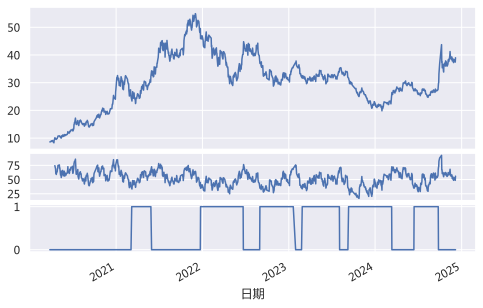

In [106]:
fig, axes = plt.subplots(3,1,figsize=(8,5), gridspec_kw={'height_ratios': [3, 1,1]},sharex = True)

df.price.plot(ax = axes[0])
rsi_14.plot(ax = axes[1])
df.pos.plot(ax = axes[2])

plt.subplots_adjust(wspace=0.05,hspace=0.05)

In [107]:
np.mean(df.lrets * df.pos.shift(1)) * 250

0.07012816372011722

In [108]:
sharpe_ratio(df.lrets)

0.6248560750848592

In [109]:
sharpe_ratio(df.lrets * df.pos.shift(1))

0.13074180984628475

In [110]:
df.loc[:,'strat_rets'] = df['lrets'] * df.pos.shift(1)

/tmp/ipykernel_201758/1941839386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'strat_rets'] = df['lrets'] * df.pos.shift(1)


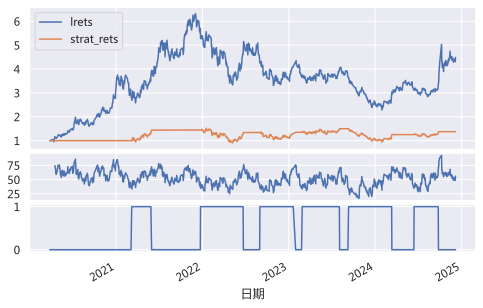

In [111]:
fig, axes = plt.subplots(3,1,figsize=(8,5), gridspec_kw={'height_ratios': [3, 1,1]},sharex = True)

df[['lrets','strat_rets']].cumsum().agg(np.exp).plot(ax = axes[0])
rsi_14.plot(ax = axes[1])
df.pos.plot(ax = axes[2])

plt.subplots_adjust(wspace=0.05,hspace=0.05)

可以优化的参数有三个，这些参数在本案中都是随机选取的:

1. 天数
2. 买入阈值
3. 卖出阈值

做法和均线系统完全一样，只是从2个参数变成3个参数，这里从略。

稍微扩展一下：

1. 在上升周期，RSI买卖信号的两个阈值可以提高（超买可以继续涨，回调不会跌太深），避免过早卖出，或者等不到买点；反之，两个信号的阈值可以降低。
2. 那么怎么区分上升下降周期？无数个方法，可以从均线想起。

## 技术分析策略组合



最后说一下策略的简单组合，这是最简单的组合多个指标的方法。这里以"单均线系统"和前面的RSI系统为例：

一般性做法是：

1. 每个系统，计算出各自的持仓情况。
2. 对不同的系统的持仓情况，求不同的逻辑组合。


例如：你可能希望“2个指标系统同时显示持有，我才持有”：

1. 价格在120均线上的同时：
2. RSI保持持仓状态（参数同前）

那么，只要2个持仓情况直接“逻辑与”，或者直接相乘也可以。

当然，你可以设置更复杂的系统。比如

1. 首先用宏观和趋势策略，判断先在处于上升周期还是下降周期。
2. 上升周期，买入更宽松：任何一个条件成立都可以买入（逻辑或）
3. 下行周期，买入更严格（或者不买入）：所有条件都成立才可以买入（逻辑与）
4. 各个区间参数还可以不一样，考虑的指标可以不一样（不考虑的指标只要乘以0即不起作用）

等等等等，各位自行发挥。


首先，各自计算2个系统的持仓。

In [112]:
# 单一均线系统的持仓情况
pos_ma = (df.price > sma(df.price,120)).shift(1)*1 # 注意要推迟1天

In [113]:
# rsi系统的持仓情况
pos_rsi = df['pos'] # 用前面的数据

按前面的逻辑：

1. 我们用120日均线来做多看判断（120日是随便选的）
2. 如果120均线多头，那么买入更加宽松：两个系统取或。注意：这个120均线多头，那么等于全程多头，rsi系统不起作用。这里只是用于演示，你的系统可能不是这样。
3. 如果120均线多头，那么买入更加严格：两个系统取与。


In [114]:
pos_ma = pos_ma.fillna(0)
pos_final = pd.DataFrame(np.where(pos_ma==1,
                     np.logical_or(pos_ma.fillna(0),pos_rsi),
                     np.logical_and(pos_ma.fillna(0),pos_rsi)),
                     index = pos_ma.index) * 1

/tmp/ipykernel_201758/369022437.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pos_ma = pos_ma.fillna(0)


<Axes: xlabel='日期'>

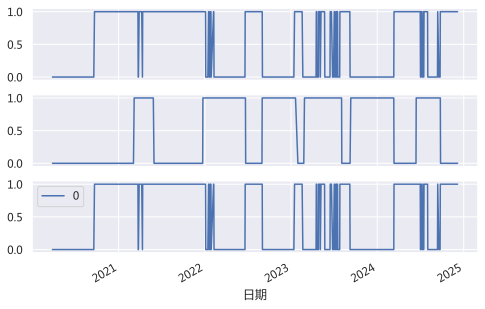

In [115]:
fig, axes = plt.subplots(3,1,figsize=(8,5), gridspec_kw={'height_ratios': [1, 1,1]},sharex = True)
pos_ma.plot(ax=axes[0])
pos_rsi.plot(ax=axes[1])
pos_final.plot(ax=axes[2])

In [116]:
df.loc[:,'lrets_final'] = (pos_final.iloc[:,0] * df.lrets)

/tmp/ipykernel_201758/67280760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'lrets_final'] = (pos_final.iloc[:,0] * df.lrets)


In [117]:

df.fillna(0,inplace=True)

df[['lrets', 'lrets_final']].cumsum().agg(np.exp).tail(5)

/tmp/ipykernel_201758/3761499522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0,inplace=True)


,lrets,lrets_final
日期,,
2024-12-02,4.413115,2.393053
2024-12-03,4.407378,2.389942
2024-12-04,4.358897,2.363653
2024-12-05,4.308770,2.336471
2024-12-06,4.486291,2.432734


<Axes: xlabel='日期'>

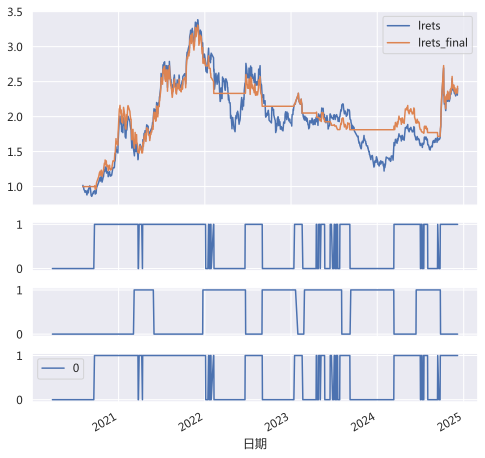

In [118]:
fig, axes = plt.subplots(4,1,figsize=(8,8), gridspec_kw={'height_ratios': [4, 1, 1, 1,]},sharex = True)
df[['lrets', 'lrets_final']].loc['2020-08':].cumsum().agg(np.exp).plot(ax=axes[0])
pos_ma.plot(ax=axes[1])
pos_rsi.plot(ax=axes[2])
pos_final.plot(ax=axes[3])


In [119]:
df[['lrets', 'lrets_final']].loc['2020-08':].agg(sharpe_ratio)

lrets          0.375415
lrets_final    0.481494
dtype: float64

很明显，现有4个参数：均线周期，rsi周期，rsi买入和卖出的阈值，都可以进行优化，各位可以自行摸索。